In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

In [3]:
from BHDVCStf import BHDVCS

In [4]:
bhdvcs = BHDVCS()

In [5]:
data = pd.read_csv('dvcs_psuedo.csv')

# For Set 0

In [6]:
data = data.loc[(data['#Set'] == 0) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [7]:
def produceLHS(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    interference = data['F'] - data['dvcs'] - bh
    interference /= bhdvcs.Gamma
    interference *= data['QQ']
    interference *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    interference /= b
    return interference

In [8]:
def produceLHSerr(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    err = data['errF']
    err /= bhdvcs.Gamma
    err *= data['QQ']
    err *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    err /= b
    return np.abs(err)

In [9]:
def aoverb(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    return a/b

In [10]:
produceLHSerr(data, bhdvcs)

0      1.289893
1      1.284265
2      1.728553
3      2.162472
4      2.951399
5      3.443826
6      4.813191
7      8.008696
8     17.248238
10    21.389384
11    11.018077
12    10.453618
13     9.106394
14    11.724380
15    12.680227
16    14.150303
17    17.081867
18    17.910911
Name: errF, dtype: float64

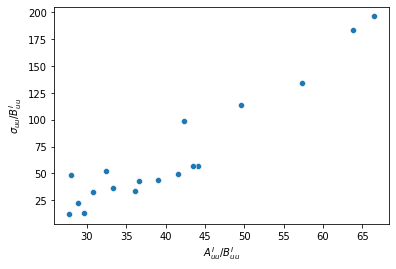

In [11]:
sns.scatterplot(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs))
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

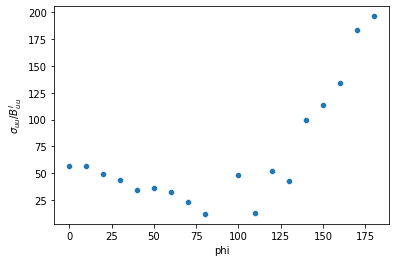

In [12]:
sns.scatterplot(x=data['phi_x'], y=produceLHS(data, bhdvcs))
plt.xlabel('phi')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

In [13]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
err = produceLHSerr(data, bhdvcs)

In [14]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.ABcon(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [15]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

### Fitted Compton Form Factors

In [16]:
cffs

array([ 14.54053928, -62.67604606])

In [17]:
np.diag(var)

array([ 2.76964485, 73.90142948])

### True CFFs

In [23]:
data.loc[0, ['ReH', 'ReE']]

ReH    13.0554
ReE   -53.0554
Name: 0, dtype: float64

In [24]:
yhat = linear_curve_fit(X, *cffs)
yhatupper = linear_curve_fit(X, *(cffs + np.diag(var)))
yhatlower = linear_curve_fit(X, *(cffs - np.diag(var)))

In [25]:
yhatwtrue = linear_curve_fit(X, 13.0554, -53.0554)

### Central Values

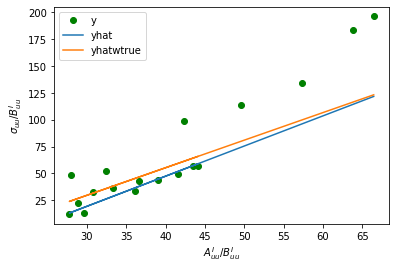

In [26]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Error from variance

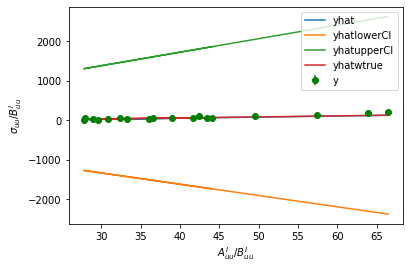

In [27]:
plt.errorbar(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), yerr=err, fmt='go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatlower, label='yhatlowerCI')
plt.plot(aoverb(data, bhdvcs), yhatupper, label='yhatupperCI')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Limits

In [140]:
high = data.copy()
high['F'] = data['F'] + data['errF']
low = data.copy()
low['F'] = data['F'] - data['errF']

In [141]:
high

,#Set,index,errF,F,phi_x,QQ,x_b,t,k,F1,F2,dvcs,ReH,ReE,ReHtilde
0,0,0,25081.524489,25138.168588,0,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
1,0,1,26351.191492,26408.281825,10,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
2,0,2,25735.520380,25784.978030,20,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
3,0,3,27506.073129,27549.801901,30,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
4,0,4,27565.719183,27599.769229,40,1.74013,0.435095,-0.380868,3.75,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,14,31,205922.720357,205958.766365,310,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
536,14,32,163100.166302,163138.850578,320,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
537,14,33,166251.770829,166301.670076,330,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
538,14,34,181674.765242,181739.540946,340,2.63258,0.345012,-0.361188,7.75,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283


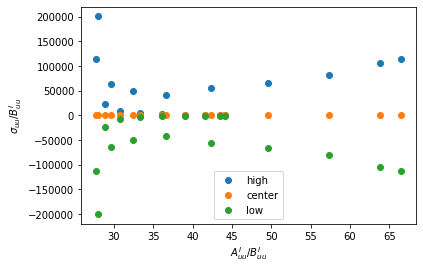

In [25]:
plt.scatter(x=aoverb(high, bhdvcs), y=produceLHS(high, bhdvcs), label='high')
plt.scatter(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs), label='center')
plt.scatter(x=aoverb(low, bhdvcs), y=produceLHS(low, bhdvcs), label='low')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Error from limits

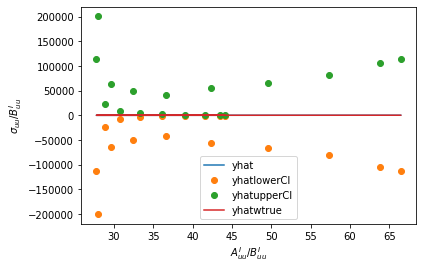

In [37]:
#plt.errorbar(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), yerr=err, fmt='go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(low, bhdvcs), produceLHS(low, bhdvcs), 'o', label='yhatlowerCI')
plt.plot(aoverb(high, bhdvcs), produceLHS(high, bhdvcs), 'o', label='yhatupperCI')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## A/B vs phi

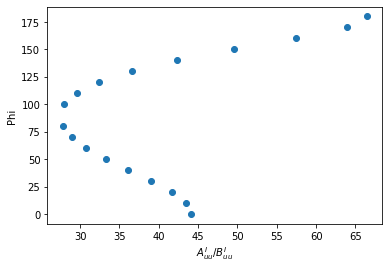

In [23]:
plt.scatter(aoverb(data, bhdvcs), data['phi_x'])
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('Phi')
plt.show()

# New Error

In [149]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
high = data.copy()
high['F'] = data['F'] + data['errF']
err = np.abs(produceLHS(high, bhdvcs) - y)

In [152]:
err = produceLHSerr(data, bhdvcs)

In [60]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

In [61]:
cffs

array([-4.14998417, 30.11224422])

In [ ]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

# Simultaneous

In [38]:
import BHDVCStf

In [39]:
import utilities

In [103]:
def combined_function(data, ReH, ReE, ReHtilde):
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    y1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    y2 = linear_curve_fit(X, ReH, ReE)
    return np.array((y1 + y2)/2)

In [163]:
data = pd.read_csv('dvcs_psuedo.csv')

In [164]:
data['F'] = produceLHS(data, bhdvcs)

In [165]:
high = data.copy()
high['F'] = high['F'] + high['errF']
data['errF'] = np.abs(produceLHS(high, bhdvcs) - data['F'])

In [167]:
data['errF'].describe()

count    5.400000e+02
mean     1.771357e+23
std      1.110558e+24
min      2.478243e+01
25%      5.754376e+04
50%      1.466405e+05
75%      5.665330e+05
max      1.004347e+25
Name: errF, dtype: float64

In [108]:
combined_function(data, 1., 1., 20.)

array([ 14.27053015,  14.18726434,  13.97456414,  13.7323913 ,
        13.59776836,  13.72086449,  14.25384534,  15.35368962,
        17.19516441,  24.01063197,  29.61165748,  37.24188467,
        47.40651283,  60.49420681,  76.30235026,  93.13221648,
       106.95007874, 112.4407308 ])

In [126]:
def produceResults(data, numSets, numReplicas):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    for i in tqdm(range(numSets)):
        seti = data.loc[(data['#Set'] == i) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]
        replicas = []
        #X = np.array(seti.XnoCFF) # the kinematics and all variables necessary to compute 
        #sigma = seti.erry 
        pars = np.array([1, 1, 1])
        for i in range(numReplicas):
            #y = seti.sampleY()
            cff, cffcov = optimize.curve_fit(combined_function, seti, seti['F'], pars, method='lm')
            replicas.append(cff)
        results.append(replicas)
    return np.array(results)

In [127]:
results = produceResults(data, 15, 1)

100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


In [130]:
import utilities as uts

In [133]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 0)

Mean percent error:  28.10510889888377
RMSE:  3.467259854776928
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -0.884910856650496


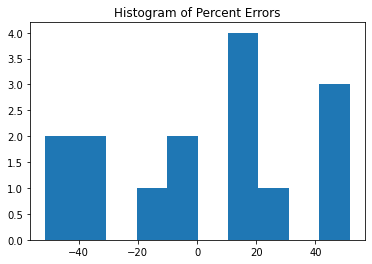

In [135]:
uts.evaluate(y_yhat)

In [136]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 1)

Mean percent error:  30.48759203241225
RMSE:  19.741552613266293
RMSE w yhat=mean:  2.525480507907797
R-squared:  -60.104693417140794


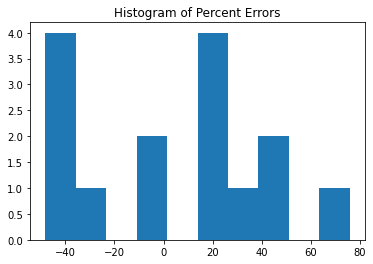

In [137]:
uts.evaluate(y_yhat)

In [138]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 2)

Mean percent error:  49.65253896508765
RMSE:  7.249909738406301
RMSE w yhat=mean:  1.4030345621243816
R-squared:  -25.701057391692828


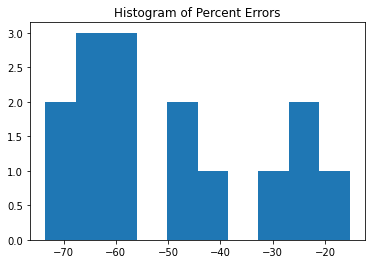

In [139]:
uts.evaluate(y_yhat)

# Optimize by average Chi-square

In [32]:
def combined_function_chisq(cffs, data):
    ReH, ReE, ReHtilde = cffs
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    yhat1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    yhat2 = linear_curve_fit(X, ReH, ReE)
    chisq1 = np.sum(((yhat1 - data['F'])/data['errF'])**2)
    chisq2 = np.sum(((yhat2 - data['F'])/data['errF'])**2)
    return (chisq1 + chisq2)/2

In [38]:
data = pd.read_csv('dvcs_psuedo.csv')
data = data.loc[(data['#Set'] == 1) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [39]:
x0 = np.array([1, 1, 1])
optimize.minimize(combined_function_chisq, x0, args=data)

      fun: 972.3773378842739
 hess_inv: array([[ 1.14446414e-09, -6.13724596e-09,  4.97406431e-09],
       [-6.13724596e-09,  5.32002090e-08, -4.69106791e-08],
       [ 4.97406431e-09, -4.69106791e-08,  4.18039318e-08]])
      jac: array([ 0.02075195, -0.00143433,  0.012146  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 9
     njev: 67
   status: 2
  success: False
        x: array([-0.0113396 ,  0.07567396, -0.00141167])

# Redo

In [1]:
import utilities as uts
from tqdm import tqdm

In [6]:
data = data.loc[(data['#Set'] == 0) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [8]:
def produceLHS(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    interference = data['F'] - data['dvcs'] - bh
    interference /= bhdvcs.Gamma
    interference *= data['QQ']
    interference *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    interference /= b
    return interference

In [9]:
def produceLHSerr(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    err = data['errF']
    err /= bhdvcs.Gamma
    err *= data['QQ']
    err *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    err /= b
    return np.abs(err)

In [10]:
def aoverb(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    return a/b

In [37]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.ABcon(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [33]:
def combined_function_chisq(cffs, data):
    ReH, ReE, ReHtilde = cffs
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    yhat1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    yhat2 = linear_curve_fit(X, ReH, ReE)
    chisq1 = np.sum(((yhat1 - data['F'])/data['errF'])**2)
    chisq2 = np.sum(((yhat2 - data['F'])/data['errF'])**2)
    return (chisq1 + chisq2)/2

In [28]:
data = pd.read_csv('dvcs_psuedo.csv')

In [29]:
high = data.copy()
high['F'] = high['F'] + high['errF']
data['errF'] = np.abs(produceLHS(high, bhdvcs) - produceLHS(data, bhdvcs))

In [30]:
data['F'] = produceLHS(data, bhdvcs)

## Set 1

In [119]:
test_data = data.loc[(data['#Set'] == 0) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [120]:
x0 = np.array([1, 1, 1])
res = optimize.minimize(combined_function_chisq, x0, args=test_data)

In [121]:
res.x

array([ 15.8791021 , -68.81298446,   3.76043883])

In [122]:
np.diag(res.hess_inv)

array([ 1.12425836, 29.73266721,  0.38083102])

## Set 2

In [123]:
test_data = data.loc[(data['#Set'] == 1) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [124]:
x0 = np.array([1, 1, 1])
res = optimize.minimize(combined_function_chisq, x0, args=test_data)

In [125]:
res.x

array([  22.80075777, -106.27311581,    3.14101246])

In [126]:
np.diag(res.hess_inv)

array([ 2.65185418, 72.37910705,  1.18399464])

In [100]:
seti = data.loc[(data['#Set'] == i) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]
rep_data = seti.copy()
rep_data['F'] = np.random.normal(rep_data['F'], rep_data['errF'])

In [101]:
rep_data

,#Set,index,errF,F,phi_x,QQ,x_b,t,k,F1,F2,dvcs,ReH,ReE,ReHtilde
72,2,0,7.386159,-36.449778,0,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
73,2,1,7.308711,-48.273208,10,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
74,2,2,7.293302,-23.867232,20,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
75,2,3,7.917898,-24.454727,30,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
76,2,4,8.741887,-36.001161,40,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
77,2,5,9.778452,-36.725486,50,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
78,2,6,11.226435,-31.586213,60,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
79,2,7,16.054382,-30.243423,70,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
80,2,8,31.530305,-78.905321,80,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347
82,2,10,26.400642,-78.402304,100,2.17955,0.385579,-0.283318,4.75,0.579414,0.848208,0.012288,7.22424,-47.2242,4.01347


In [108]:
np.array([, np.random.normal(res.x, np.diag(res.hess_inv), size=(10, 3))])

array([[[  19.89816508,  -88.34121367,    4.16433741],
        [  25.51979272, -115.75732595,    4.59676969],
        [  23.56839302,  -72.88467036,    2.53200944],
        [  26.86312547,  -91.74153215,    3.46497155],
        [  20.73871708, -287.54265193,    3.57678543],
        [  24.01563157,    1.20282739,    3.06943454],
        [  21.69141536, -140.09653075,    4.24545324],
        [  22.65614068,  -77.97815981,    3.91353327],
        [  22.59310269,  -99.92002087,    2.71104807],
        [  18.50843565, -197.46597487,    4.00077812]],

       [[  20.62384541, -160.63609382,    1.19334125],
        [  26.99151647,   23.83793832,    3.50546693],
        [  23.67283548, -115.75091353,    3.94521585],
        [  19.53855812, -152.97019707,    2.45278248],
        [  23.23834906,   34.35692924,    3.90016106],
        [  21.72492143, -142.7226738 ,    3.89953589],
        [  24.27088822,   -3.68752385,    0.76589982],
        [  24.34931396, -256.00170037,    0.90076853],
        

In [136]:
def produceResults(data, numSets, numReplicas):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    for i in tqdm(range(numSets)):
        seti = data.loc[(data['#Set'] == i) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]
        replicas = []
        #X = np.array(seti.XnoCFF) # the kinematics and all variables necessary to compute 
        #sigma = seti.erry 
        pars = np.array([1, 1, 1])
        optobj = optimize.minimize(combined_function_chisq, x0, args=seti)
        results.append(np.random.normal(res.x, np.diag(res.hess_inv), size=(numReplicas, 3)))
    return np.array(results)

In [110]:
results = produceResults(data, 15, 10)

100%|██████████| 15/15 [02:24<00:00,  9.61s/it]


In [115]:
localFits = np.fromfile('replicas500.txt')
localFits = localFits.reshape(15, 500, 3)

## ReH

Mean percent error:  57.56907125751066
RMSE:  13.261677918395833
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -26.574966009710646


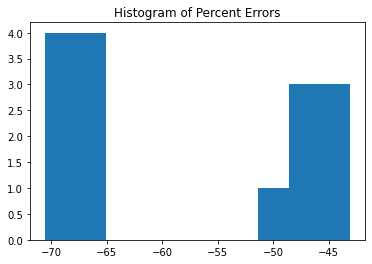

In [116]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 0)
uts.evaluate(y_yhat)

In [127]:
y_yhatlocal, errlocal = uts.y_yhat_errCFFs(uts.DvcsData(data), localFits, 0)

In [128]:
def plotError(y_yhat, orig_y, errs, orig_err, var_string, title=None):
    '''
    :param y_yhat: numpy array of what it sounds like
    :param errs: list or array of stds of variable
    :param var_string: string of which variable is being plotted
    '''
    assert len(y_yhat) == len(errs)
    
    fig, ax = plt.subplots()
    ax.errorbar(x=list(range(len(errs))),
                 y=list(map(lambda x: x[1], y_yhat)),
                yerr=errs,
                fmt='o',
                label="Estimated " + var_string)
    ax.plot(list(range(len(errs))),
             list(map(lambda x: x[0], y_yhat)),
             'ro', label="Actual " + var_string)
    
    ax.errorbar(x=list(range(len(orig_err))),
             y=list(map(lambda x: x[1], orig_y)),
            yerr=errs,
            fmt='o',
            label="Baseline " + var_string)
    
    ax.set_xlabel("Set#")
    ax.set_ylabel(var_string)
    if title != None:
        ax.set_title(title)
        
    ax.legend()
    
    plt.show()

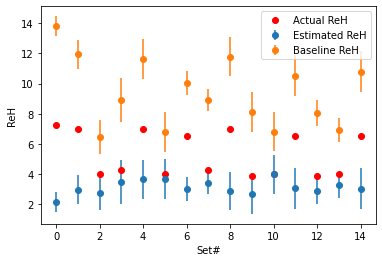

In [129]:
plotError(y_yhat, y_yhatlocal, err, errlocal, 'ReH')

## ReE

Mean percent error:  51.38145231181199
RMSE:  59.22706436860226
RMSE w yhat=mean:  2.525480507907797
R-squared:  -548.9869342579308


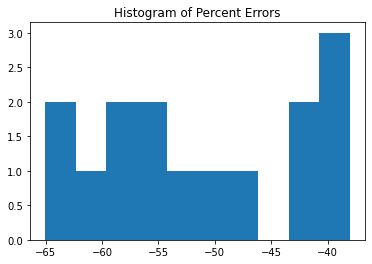

In [130]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 1)
uts.evaluate(y_yhat)

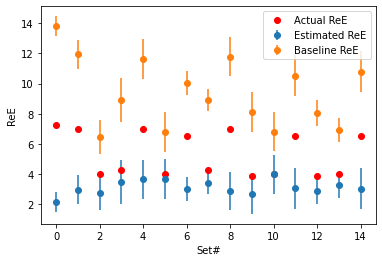

In [135]:
plotError(y_yhat, y_yhatlocal, err, errlocal, 'ReE')

## ReHtilde

Mean percent error:  77.53068591303303
RMSE:  2.7441047078320144
RMSE w yhat=mean:  1.4030345621243816
R-squared:  -2.8252922340236393


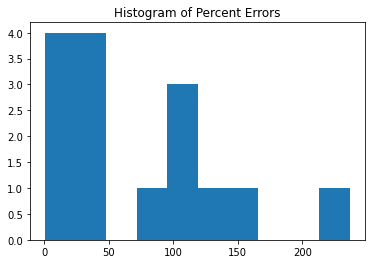

In [132]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 2)
uts.evaluate(y_yhat)

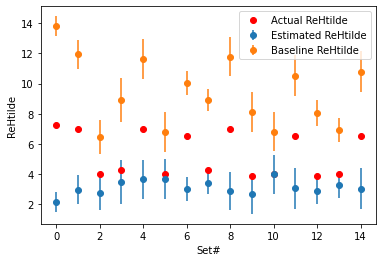

In [134]:
plotError(y_yhat, y_yhatlocal, err, errlocal, 'ReHtilde')